In [13]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter

# 定义状态转移函数
def f(x, dt):
    """状态转移函数"""
    x_new = np.zeros_like(x)
    x_new[0] = x[0] + dt * np.cos(x[2])  # x位置
    x_new[1] = x[1] + dt * np.sin(x[2])  # y位置
    x_new[2] = x[2]  # 航向角保持不变
    return x_new

def h(x):
    """观测函数"""
    return np.array([x[0], x[1]])  # 只观测位置

# EKF 实现
def ekf_example():
    dt = 0.1  # 时间间隔
    ekf = ExtendedKalmanFilter(dim_x=3, dim_z=2)

    ekf.x = np.array([0., 0., 0.])  # 初始状态
    ekf.P *= 10.  # 初始不确定性
    ekf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
    ekf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

    # 进行预测和更新
    for _ in range(100):
        # 预测
        ekf.predict()
        # 更新
        z = np.array([ekf.x[0] + np.random.normal(0, 0.1), ekf.x[1] + np.random.normal(0, 0.1)])
        ekf.update(z, HJacobian=ekf.jacobian, Hx=h)

    return ekf

# UKF 实现
def ukf_example():
    dt = 0.1  # 时间间隔
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2)

    ukf.x = np.array([0., 0., 0.])  # 初始状态
    ukf.P *= 10.  # 初始不确定性
    ukf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
    ukf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

    # 设置状态转移和观测函数
    ukf.f = f
    ukf.h = h

    # 进行预测和更新
    for _ in range(100):
        # 预测
        ukf.predict()
        # 更新
        z = np.array([ukf.x[0] + np.random.normal(0, 0.1), ukf.x[1] + np.random.normal(0, 0.1)])
        ukf.update(z)

    return ukf

# 获取两个滤波器的结果
ekf_result = ekf_example()
ukf_result = ukf_example()

# 绘制结果对比
plt.plot(ekf_result.x[0], ekf_result.x[1], 'ro', label='EKF估计')
plt.plot(ukf_result.x[0], ukf_result.x[1], 'bo', label='UKF估计')
plt.xlabel('x位置')
plt.ylabel('y位置')
plt.legend()
plt.title('无人机姿态估计对比')
plt.show()


AttributeError: 'ExtendedKalmanFilter' object has no attribute 'jacobian'

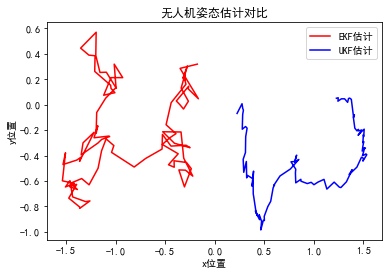

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints  # 导入 JulierSigmaPoints

# 状态转移函数
def f(x, dt):
    """状态转移函数"""
    x_new = np.copy(x)  # 使用 np.copy 避免不必要的内存分配
    x_new[0] += dt * np.cos(x[2])  # x位置
    x_new[1] += dt * np.sin(x[2])  # y位置
    # 航向角保持不变，无需修改
    return x_new

# 状态转移的雅可比矩阵
def F_jacobian(x, dt):
    """状态转移函数的雅可比矩阵"""
    sin_theta = np.sin(x[2])  # 避免重复计算
    cos_theta = np.cos(x[2])  # 避免重复计算
    return np.array([[1, 0, -dt * sin_theta],
                     [0, 1, dt * cos_theta],
                     [0, 0, 1]])

# 观测函数
def h(x):
    """观测函数"""
    return x[:2]  # 直接返回前两个元素，避免创建新数组

# 观测函数的雅可比矩阵
def H_jacobian(x):
    """观测函数的雅可比矩阵"""
    return np.array([[1, 0, 0],
                     [0, 1, 0]])

# EKF 实现
def ekf_example():
    try:
        dt = 0.1  # 时间间隔
        ekf = ExtendedKalmanFilter(dim_x=3, dim_z=2)

        ekf.x = np.array([0., 0., 0.])  # 初始状态
        ekf.P *= 10.  # 初始不确定性
        ekf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
        ekf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

        # 记录轨迹
        trajectory = []

        # 进行预测和更新
        for _ in range(100):
            # 预测
            ekf.predict()
            
            # 生成观测值（基于真实状态，而不是滤波器估计的状态）
            true_state = np.array([ekf.x[0] + np.random.normal(0, 0.1), 
                                   ekf.x[1] + np.random.normal(0, 0.1)])
            z = true_state + np.random.normal(0, 0.1, size=2)  # 添加观测噪声
            
            # 更新
            ekf.update(z, HJacobian=H_jacobian, Hx=h)
            
            # 记录当前状态
            trajectory.append(ekf.x.copy())
        
        return np.array(trajectory)  # 返回完整的轨迹
    except Exception as e:
        print(f"EKF 执行过程中发生错误: {e}")
        return None


# UKF 实现
def ukf_example():
    try:
        dt = 0.1  # 时间间隔
        # 使用 JulierSigmaPoints 初始化 UKF
        points = JulierSigmaPoints(n=3, kappa=0)  # n 是状态维度，kappa 是缩放参数
        ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2, dt=dt, hx=h, fx=f, points=points)

        ukf.x = np.array([0., 0., 0.])  # 初始状态
        ukf.P *= 100.  # 增加初始不确定性
        ukf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
        ukf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.1)  # 过程噪声协方差

        # 记录轨迹
        trajectory = []

        # 进行预测和更新
        for _ in range(100):
            # 预测
            ukf.predict()
            
            # 生成观测值（基于真实状态，而不是滤波器估计的状态）
            true_state = np.array([ukf.x[0] + np.random.normal(0, 0.1), 
                                   ukf.x[1] + np.random.normal(0, 0.1)])
            z = true_state + np.random.normal(0, 0.1, size=2)  # 添加观测噪声
            
            # 更新
            ukf.update(z)
            
            # 记录当前状态
            trajectory.append(ukf.x.copy())
        
        return np.array(trajectory)  # 返回完整的轨迹
    except Exception as e:
        print(f"UKF 执行过程中发生错误: {e}")
        return None

# 获取两个滤波器的结果
ekf_result = ekf_example()
ukf_result = ukf_example()

# 绘制结果对比
if ekf_result is not None and ukf_result is not None:
    plt.plot(ekf_result[:, 0], ekf_result[:, 1], 'r-', label='EKF估计')  # 绘制完整轨迹
    plt.plot(ukf_result[:, 0], ukf_result[:, 1], 'b-', label='UKF估计')  # 绘制完整轨迹
    plt.xlabel('x位置')
    plt.ylabel('y位置')
    plt.legend()
    plt.title('无人机姿态估计对比')
    plt.show()
else:
    print("无法绘制结果，因为 EKF 或 UKF 执行失败。")


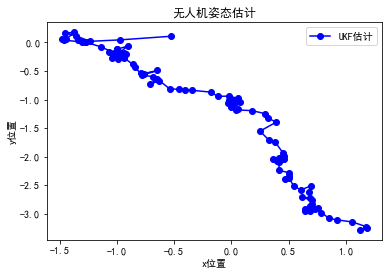

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

# 状态转移函数
def f(x, dt):
    """状态转移函数"""
    x_new = np.zeros_like(x)
    x_new[0] = x[0] + dt * np.cos(x[2])  # x位置
    x_new[1] = x[1] + dt * np.sin(x[2])  # y位置
    x_new[2] = x[2]  # 航向角保持
    return x_new

# 观测函数
def h(x):
    """观测函数"""
    return np.array([x[0], x[1]])

# UKF 实现
def ukf_example():
    dt = 0.1  # 时间间隔

    # 初始化 UKF
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2, dt=dt,
                                 hx=h, fx=f, points=MerweScaledSigmaPoints(n=3, alpha=0.1, beta=2.0, kappa=0))

    ukf.x = np.array([0., 0., 0.])  # 初始状态
    ukf.P *= 10.  # 初始不确定性
    ukf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
    ukf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

    # 保存历史数据
    history_x = []
    history_y = []

    # 进行预测和更新
    for _ in range(100):
        # 预测
        ukf.predict()
        
        # 更新
        z = np.array([ukf.x[0] + np.random.normal(0, 0.1), 
                      ukf.x[1] + np.random.normal(0, 0.1)])
        
        ukf.update(z)

        # 保存当前状态
        history_x.append(ukf.x[0])
        history_y.append(ukf.x[1])

    return history_x, history_y

# 获取UKF的结果
history_x, history_y = ukf_example()

# 绘制结果
plt.plot(history_x, history_y, 'bo-', label='UKF估计')
plt.xlabel('x位置')
plt.ylabel('y位置')
plt.legend()
plt.title('无人机姿态估计')
plt.show()


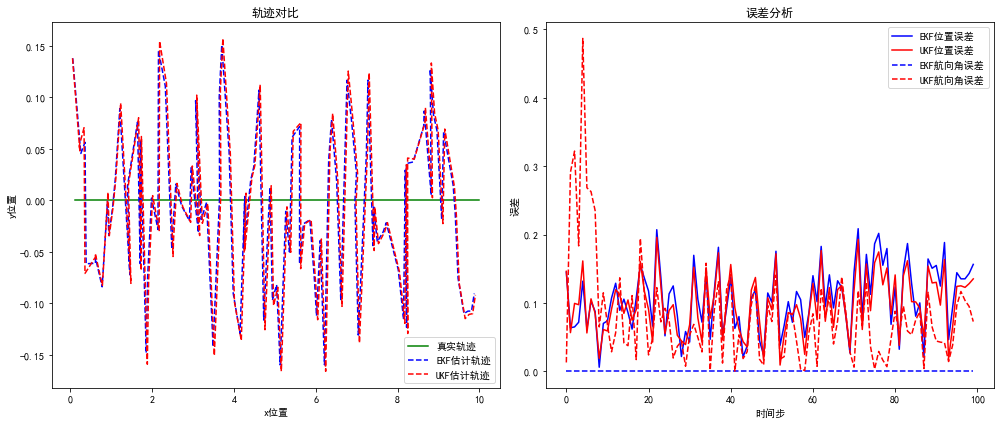

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints

# 状态转移函数
def f(x, dt):
    """状态转移函数"""
    x_new = np.zeros_like(x)
    x_new[0] = x[0] + dt * np.cos(x[2])  # x位置
    x_new[1] = x[1] + dt * np.sin(x[2])  # y位置
    x_new[2] = x[2]  # 航向角保持
    return x_new

# 状态转移的雅可比矩阵
def F_jacobian(x, dt):
    """状态转移函数的雅可比矩阵"""
    return np.array([[1, 0, -dt * np.sin(x[2])],
                     [0, 1, dt * np.cos(x[2])],
                     [0, 0, 1]])

# 观测函数
def h(x):
    """观测函数"""
    return np.array([x[0], x[1]])

# 观测函数的雅可比矩阵
def H_jacobian(x):
    """观测函数的雅可比矩阵"""
    return np.array([[1, 0, 0],
                     [0, 1, 0]])

# 生成真实姿态数据
def generate_true_states(dt, num_steps):
    """生成真实姿态数据"""
    true_states = []
    x = np.array([0., 0., 0.])  # 初始状态
    for _ in range(num_steps):
        x = f(x, dt)  # 更新状态
        true_states.append(x)
    return np.array(true_states)

# 生成带噪声的观测数据
def generate_observations(true_states, noise_std):
    """生成带噪声的观测数据"""
    observations = []
    for state in true_states:
        z = h(state) + np.random.normal(0, noise_std, size=2)  # 添加噪声
        observations.append(z)
    return np.array(observations)

# EKF 实现
def ekf_example(true_states, observations, dt):
    """EKF实现"""
    # 初始化 EKF
    ekf = ExtendedKalmanFilter(dim_x=3, dim_z=2)

    ekf.x = np.array([0., 0., 0.])  # 初始状态
    ekf.P *= 10.  # 初始不确定性
    ekf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
    ekf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

    # 保存历史数据
    estimated_states = []

    # 进行预测和更新
    for z in observations:
        # 预测
        ekf.predict()
        
        # 更新
        ekf.update(z, HJacobian=H_jacobian, Hx=h)

        # 保存当前估计状态
        estimated_states.append(ekf.x.copy())

    return np.array(estimated_states)

# UKF 实现
def ukf_example(true_states, observations, dt):
    """UKF实现"""
    # 初始化 UKF
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2, dt=dt,
                                hx=h, fx=f, points=MerweScaledSigmaPoints(n=3, alpha=0.1, beta=2.0, kappa=0))

    ukf.x = np.array([0., 0., 0.])  # 初始状态
    ukf.P *= 10.  # 初始不确定性
    ukf.R = np.diag([0.1, 0.1])  # 观测噪声协方差
    ukf.Q = np.diag([0.1, 0.1, 0.1])  # 过程噪声协方差

    # 保存历史数据
    estimated_states = []

    # 进行预测和更新
    for z in observations:
        # 预测
        ukf.predict()
        
        # 更新
        ukf.update(z)

        # 保存当前估计状态
        estimated_states.append(ukf.x.copy())

    return np.array(estimated_states)

# 计算误差
def calculate_errors(true_states, estimated_states):
    """计算误差"""
    position_errors = np.sqrt((true_states[:, 0] - estimated_states[:, 0])**2 +
                              (true_states[:, 1] - estimated_states[:, 1])**2)
    angle_errors = np.abs(true_states[:, 2] - estimated_states[:, 2])
    return position_errors, angle_errors

# 主函数
def main():
    dt = 0.1  # 时间间隔
    num_steps = 100  # 时间步数
    noise_std = 0.1  # 观测噪声标准差

    # 生成真实姿态数据
    true_states = generate_true_states(dt, num_steps)

    # 生成带噪声的观测数据
    observations = generate_observations(true_states, noise_std)

    # EKF估计
    ekf_estimated_states = ekf_example(true_states, observations, dt)

    # UKF估计
    ukf_estimated_states = ukf_example(true_states, observations, dt)

    # 计算误差
    ekf_position_errors, ekf_angle_errors = calculate_errors(true_states, ekf_estimated_states)
    ukf_position_errors, ukf_angle_errors = calculate_errors(true_states, ukf_estimated_states)

    # 绘制结果
    plt.figure(figsize=(14, 6))

    # 绘制轨迹
    plt.subplot(1, 2, 1)
    plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='真实轨迹')
    plt.plot(ekf_estimated_states[:, 0], ekf_estimated_states[:, 1], 'b--', label='EKF估计轨迹')
    plt.plot(ukf_estimated_states[:, 0], ukf_estimated_states[:, 1], 'r--', label='UKF估计轨迹')
    plt.xlabel('x位置')
    plt.ylabel('y位置')
    plt.legend()
    plt.title('轨迹对比')

    # 绘制误差
    plt.subplot(1, 2, 2)
    plt.plot(ekf_position_errors, 'b-', label='EKF位置误差')
    plt.plot(ukf_position_errors, 'r-', label='UKF位置误差')
    plt.plot(ekf_angle_errors, 'b--', label='EKF航向角误差')
    plt.plot(ukf_angle_errors, 'r--', label='UKF航向角误差')
    plt.xlabel('时间步')
    plt.ylabel('误差')
    plt.legend()
    plt.title('误差分析')

    plt.tight_layout()
    plt.show()

# 运行主函数
if __name__ == "__main__":
    main()
